In [1]:
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
from scipy.stats import norm

tf.compat.v1.disable_eager_execution()

/Users/shankar/opt/miniconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/shankar/opt/miniconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/shankar/opt/miniconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/shanka

In [2]:
from mpl_toolkits.mplot3d import Axes3D


In [3]:
dimension_state = 2

riskfree_rate = 0.05
volatility = 0.25 
strike_price = 0.5
correlation = 0.1

# Time limits
T_min = 0.
T_max  = 1.

# Space limits
S_min = 0.
S_max = 1.

# Network parameters
nr_layers = 3
nr_nodes_per_layer = 50
initial_learning_rate = 0.001
learning_rate_decay_steps = 10000
learning_rate_decay_rate = 1.0

# Training parameters
steps_per_sample = 10
nr_epochs = 1000

# Number of samples
N_interior = 12000
N_initial = 12000

payoff_geometric = False

In [4]:
# Loss function
def get_residual(model, t_interior, x_interior, t_initial, x_initial):
    # Loss term #1: PDE
    V = model(t_interior, x_interior)
    V_t = tf.gradients(V, t_interior)[0]
    V_x = tf.gradients(V, x_interior)[0]
    
    grad_V = [tf.slice(V_x, (0, i), (-1,1)) for i in range(dimension_state)]
    
    V_xx = [tf.gradients(grad_V[i], x_interior)[0] for i in range(dimension_state)]
    Hessian_V = [[tf.slice(V_xx[i], (0, j), (-1, 1)) for j in range(dimension_state)] for i in range(dimension_state)]

    x_interior_sliced = [tf.slice(x_interior, (0, i), (-1, 1)) for i in range(dimension_state)]
    
    f = -V_t + riskfree_rate * V 
    for i in range(dimension_state):
        volatility_i = volatility
        f-=riskfree_rate*x_interior_sliced[i]*grad_V[i]
        for j in range(dimension_state):
            volatility_j = volatility
            correlation_ij = 1 if i==j else correlation
            f -= 0.5 * volatility_i * volatility_j * correlation_ij * x_interior_sliced[i] * x_interior_sliced[j] *\
                Hessian_V[i][j]

    L1 = tf.reduce_mean(tf.square(f))

    #Loss term #2: initial/terminal condition
    x_interior_sliced = [tf.slice(x_interior, (0, i), (-1, 1)) for i in range(dimension_state)]
    
    payoff=tf.math.maximum(0.,tf.subtract(strike_price,(sum(x_interior_sliced)/dimension_state)))
    
    L2=tf.reduce_mean(tf.square(tf.math.maximum(0.,payoff-V)))
    
    
    # Loss term #3: initial/terminal condition
    x_initial_sliced = [tf.slice(x_initial, (0, i), (-1, 1)) for i in range(dimension_state)]
    
    L3 = tf.reduce_mean(tf.square(
        model(t_initial,x_initial) - tf.math.maximum(0., sum(x_initial_sliced)/dimension_state - strike_price)))

    return (L1,L2,L3)


In [5]:
# DGM neural network model
class DNN(tf.keras.Model):
    def __init__(self, nr_layers, nr_nodes_each_layer, dimension_state=1):
        tf.keras.Model.__init__(self)
        
        self.nr_layers = nr_layers

        self.initial_layer = DenseLayer(dimension_state + 1, nr_nodes_each_layer, activation=tf.nn.tanh)
        self.hidden_layers = []
        for _ in range(nr_layers):
            self.hidden_layers.append(LayerFromPaper(dimension_state + 1, nr_nodes_each_layer, activation=tf.nn.tanh))
        self.final_layer = DenseLayer(nr_nodes_each_layer, 1, activation=None)


    def call(self, t, x):
        X = tf.concat([t,x], 1)

        S = self.initial_layer.call(X)
        for i in range(self.nr_layers):
            S = self.hidden_layers[i].call({'S': S, 'X': X})
        result = self.final_layer.call(S)

        return result
    


# Neural network layers

class DenseLayer(tf.keras.layers.Layer):
    def __init__(self, nr_inputs, nr_outputs, activation):
        tf.keras.layers.Layer.__init__(self)
        
        self.initializer = tf.keras.initializers.glorot_normal
        #self.initializer=tf.contrib.layers.xavier_initializer()) #TF 1

        self.nr_inputs = nr_inputs
        self.nr_outputs = nr_outputs
        
        self.W = self.add_variable("W", shape=[self.nr_inputs, self.nr_outputs],
                                   initializer=self.initializer())
        self.b = self.add_variable("b", shape=[1, self.nr_outputs])

        self.activation = activation
    
    
    def call(self, inputs):
        S = tf.add(tf.matmul(inputs, self.W), self.b)
        if not self.activation == None:
            S = self.activation(S)

        return S



class LayerFromPaper(tf.keras.layers.Layer):
    def __init__(self, nr_inputs, nr_outputs, activation):
        tf.keras.layers.Layer.__init__(self)

        self.initializer = tf.keras.initializers.glorot_normal
        #self.initializer=tf.contrib.layers.xavier_initializer()) #TF 1
        
        self.nr_outputs = nr_outputs
        self.nr_inputs = nr_inputs

        self.Uz = self.add_variable("Uz", shape=[self.nr_inputs, self.nr_outputs],
                                    initializer=self.initializer())
        self.Ug = self.add_variable("Ug", shape=[self.nr_inputs, self.nr_outputs],
                                    initializer=self.initializer())
        self.Ur = self.add_variable("Ur", shape=[self.nr_inputs, self.nr_outputs],
                                    initializer=self.initializer())
        self.Uh = self.add_variable("Uh", shape=[self.nr_inputs, self.nr_outputs],
                                    initializer=self.initializer())
        self.Wz = self.add_variable("Wz", shape=[self.nr_outputs, self.nr_outputs],
                                    initializer=self.initializer())
        self.Wg = self.add_variable("Wg", shape=[self.nr_outputs, self.nr_outputs],
                                    initializer=self.initializer())
        self.Wr = self.add_variable("Wr", shape=[self.nr_outputs, self.nr_outputs],
                                    initializer=self.initializer())
        self.Wh = self.add_variable("Wh", shape=[self.nr_outputs, self.nr_outputs],
                                    initializer=self.initializer())
        self.bz = self.add_variable("bz", shape=[1, self.nr_outputs])
        self.bg = self.add_variable("bg", shape=[1, self.nr_outputs])
        self.br = self.add_variable("br", shape=[1, self.nr_outputs])
        self.bh = self.add_variable("bh", shape=[1, self.nr_outputs])

        self.activation = activation

    
    def call(self, inputs):
        S = inputs['S']
        X = inputs['X']

        Z = self.activation(tf.add(tf.add(tf.matmul(X, self.Uz), tf.matmul(S, self.Wz)), self.bz))
        G = self.activation(tf.add(tf.add(tf.matmul(X, self.Ug), tf.matmul(S, self.Wg)), self.bg))
        R = self.activation(tf.add(tf.add(tf.matmul(X, self.Ur), tf.matmul(S, self.Wr)), self.br))
        H = self.activation(tf.add(tf.add(tf.matmul(X, self.Uh), tf.matmul(tf.multiply(S, R), self.Wh)), self.bh))
        Snew = tf.add(tf.multiply(tf.subtract(tf.ones_like(G), G), H), tf.multiply(Z, S))

        return Snew

In [6]:
# Sampling
def get_monte_carlo_points(N_interior, N_initial, dimension_state=1):
    # Sampler #1: PDE domain
    t_interior = np.random.uniform(low=T_min - 0.5*(T_max - T_min),
                           high=T_max,
                           size=[N_interior,1])
    s_interior = np.random.uniform(low=S_min - (S_max - S_min)*0.5,
                           high=S_max + (S_max - S_min)*0.5,
                           size=[N_interior,dimension_state])
    
    # Sampler #2: initial/terminal condition
    t_initial = T_max * np.ones((N_initial,1)) #Terminal condition
    s_initial = np.random.uniform(low=S_min - (S_max - S_min)*0.0,
                           high=S_max + (S_max - S_min)*0.5,
                           size=[N_initial,dimension_state])
    
    return (t_interior, s_interior, t_initial, s_initial)

In [7]:
# Neural Network definition

model = DNN(nr_layers, nr_nodes_per_layer, dimension_state=dimension_state)

t_interior_tf = tf.compat.v1.placeholder(tf.float32, shape=(None, 1), name="time_interior")
x_interior_tf = tf.compat.v1.placeholder(tf.float32, shape=(None, dimension_state), name="stock_prices_interior")
t_initial_tf = tf.compat.v1.placeholder(tf.float32, shape=(None, 1), name="time_initial")
x_initial_tf = tf.compat.v1.placeholder(tf.float32, shape=(None, dimension_state), name="stock_prices_initial")

residual_interior, residual_exterior,residual_initial = get_residual(model, t_interior_tf, x_interior_tf, t_initial_tf, x_initial_tf)
residual = residual_interior + residual_initial+residual_exterior

# Optimizer parameters
nr_steps = tf.Variable(0, trainable=False)
learning_rate = tf.compat.v1.train.exponential_decay(initial_learning_rate, nr_steps,
                                           learning_rate_decay_steps, 
                                           learning_rate_decay_rate, staircase=True)
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate).minimize(residual)




# Plot tensors
tplot_t = tf.compat.v1.placeholder(tf.float32, [None,1], name="tplot_t") # We name to recover it later
xplot_t = tf.compat.v1.placeholder(tf.float32, [None,dimension_state], name="xplot_t")
vplot_t = tf.identity(model(tplot_t, xplot_t), name="vplot_t") # Trick for naming the trained model


# Training data holders
residuals_list = []

# Train network!!
init_op = tf.compat.v1.global_variables_initializer()




Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [8]:
# before opening a tensorflow session, close the old one if possible

try:
    sess.close()
except NameError:
    pass 
sess =  tf.compat.v1.Session()

sess.run(init_op)

for epoch in range(nr_epochs):
    t_interior_mc, x_interior_mc, t_initial_mc, x_initial_mc = get_monte_carlo_points(N_interior, N_initial, dimension_state)

    for _ in range(steps_per_sample):
        residual_value, residual_interior_value,residual_exterior_value, residual_initial_value, _ = \
            sess.run([residual, residual_interior,residual_exterior, residual_initial, optimizer],
                  feed_dict = {t_interior_tf:t_interior_mc, x_interior_tf:x_interior_mc,
                                t_initial_tf:t_initial_mc, x_initial_tf:x_initial_mc})


    residuals_list.append(residual_value)

    if (not np.mod(epoch, 100)) or epoch==nr_epochs+1:
        print("Stage: {:04d}, Loss: {:e}, L1: {:e},L2: {:e}, L3: {:e}".format(
            epoch, residual_value, residual_interior_value,residual_exterior_value,residual_initial_value) )

Stage: 0000, Loss: 3.638627e-01, L1: 2.298537e-01,L2: 2.900447e-05, L3: 1.339800e-01
Stage: 0100, Loss: 3.999725e-03, L1: 6.284923e-04,L2: 1.496093e-03, L3: 1.875140e-03
Stage: 0200, Loss: 3.621360e-03, L1: 6.552555e-04,L2: 1.452489e-03, L3: 1.513616e-03
Stage: 0300, Loss: 3.117074e-03, L1: 6.650620e-04,L2: 1.325264e-03, L3: 1.126747e-03
Stage: 0400, Loss: 2.948675e-03, L1: 6.319959e-04,L2: 1.338800e-03, L3: 9.778782e-04
Stage: 0500, Loss: 2.710985e-03, L1: 6.001404e-04,L2: 1.336939e-03, L3: 7.739051e-04
Stage: 0600, Loss: 2.593038e-03, L1: 6.048465e-04,L2: 1.283184e-03, L3: 7.050080e-04
Stage: 0700, Loss: 2.408925e-03, L1: 6.220408e-04,L2: 1.145726e-03, L3: 6.411583e-04
Stage: 0800, Loss: 2.441119e-03, L1: 6.759391e-04,L2: 1.171758e-03, L3: 5.934223e-04
Stage: 0900, Loss: 2.483454e-03, L1: 6.267611e-04,L2: 1.196893e-03, L3: 6.597994e-04


In [16]:
def my_plot_2d_model(xlim=(0, 1), t=1, num_points = 30):
    
    
    x1s = np.linspace(*xlim, num_points)
    x2s = np.linspace(*xlim, num_points)
    
    x1s_grid, x2s_grid = np.meshgrid(x1s, x2s)
    grid = np.concatenate((x1s_grid.reshape(-1,1), x2s_grid.reshape(-1,1)), axis=1)
    tt = t*np.ones((num_points**2,1))

    approxs = sess.run(vplot_t, feed_dict={tplot_t:tt, xplot_t:grid}).reshape(num_points, num_points)
    
    fig = plt.figure()
    axis = fig.gca(projection='3d')
    axis.plot_surface(x1s_grid, x2s_grid, np.transpose(approxs), rstride=1, cstride=1,
                      cmap='viridis', edgecolor='none')
    axis.set_title('PDE - approximate solution', size=17)
    axis.set_xlabel(r'$x1$', fontdict={'fontsize': 14})
    axis.set_ylabel(r'$x2$', fontdict={'fontsize': 14})
    axis.view_init(azim=120)
    plt.savefig('3D put model multidim', dpi=100, bbox_inches='tight')
    plt.show()

In [17]:
if payoff_geometric:
    V_T = lambda x:  np.maximum(np.prod(x, axis=1)**(1/dimension_state)-strike_price, 0)
else:
    V_T = lambda x:  np.maximum(np.mean(x, axis=1)-strike_price, 0)

In [18]:
# cumulative density function of standard normal random variable
def N(x):
    return norm.cdf(x)

In [19]:
# european call value analytical
def V(S, K, T, r, sigma, rho):
    if not payoff_geometric:
        return None
    d = np.size(S, axis=1)
    S_mean = np.prod(S, axis=1)**(1/d)
    if T>0:
        vola_1d = ((d + d * (d - 1) * rho) / (d ** 2)) ** 0.5 * sigma
        drift = - vola_1d ** 2 * 0.5 + sigma ** 2 * 0.5
        d1 = (1 / ( vola_1d * np.math.sqrt(T) ) ) * (
                np.log( S_mean / K ) + (r - drift + vola_1d**2 / 2) * (T) )
        d2 = d1 - vola_1d * np.math.sqrt(T)
        res = np.math.exp(-drift*T) * N(d1) * S_mean - N(d2) * K * np.math.exp(-1 * r * (T))
        return res
    else:
        return V_T(S)

In [20]:
def plot_V_2d(Slim = (0, 1), t=1, num_points = 20):
    from mpl_toolkits.mplot3d import Axes3D
    
    S1s = np.linspace(*Slim, num_points)
    S2s = np.linspace(*Slim, num_points)
        
    S1s_grid, S2s_grid = np.meshgrid(S1s, S2s)
    ts = t
    
    Vs = np.zeros((num_points, num_points))
    
    for i in range(num_points):
        for j in range(num_points):
            Vs[i][j] = V(np.array((S1s[i], S2s[j])).reshape(1,-1), strike_price, 1-ts, riskfree_rate, volatility, correlation)
    
    fig = plt.figure()
    axis = fig.gca(projection='3d')
    axis.plot_surface(S1s_grid, S2s_grid, np.transpose(Vs), rstride=1, cstride=1,
                      cmap='plasma', edgecolor='none')
    axis.set_title('analytic option price', size=17)
    axis.set_xlabel(r'$S1$', fontdict={'fontsize': 14})
    axis.set_ylabel(r'$S2$', fontdict={'fontsize': 14})
    axis.view_init(azim=135)
    plt.show()

/Users/shankar/opt/miniconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Z contains NaN values. This may result in rendering artifacts.


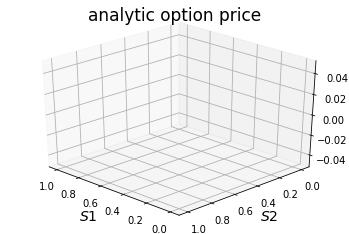

In [21]:
plot_V_2d(t=0)

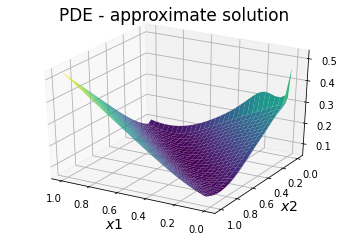

In [22]:
my_plot_2d_model(t=0)